In this example we will take a look at the simulated data. Data was obtained using SPPARKS kinetic Monte-Carlo simulator for 2 phase ising model. The model is in 2D and the volume fraction of one phase is varied for different simulations. Microstructures are assumed to be periodic.


First, we load the data:

In [49]:
from pymks_share import DataManager
import numpy as np

manager = DataManager('pymks.me.gatech.edu')
X = manager.fetch_data('2 phase ising model')
Y = manager.fetch_data('Ising 30%')
Z = manager.fetch_data('ising 10%')
R1 = manager.fetch_data('Ising 40%_Run#1')
R2 = manager.fetch_data('Ising 40%_Run#3')
X.shape, R1.shape 

((201, 100, 100), (201, 100, 100))

'X' refers to 50% volume fraction and the rest of the data has its volume fraction in its name.

Let's take a look how initial microstructures look like for three different volume fractions (50%, 30%, 10%) using draw_microstructures:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


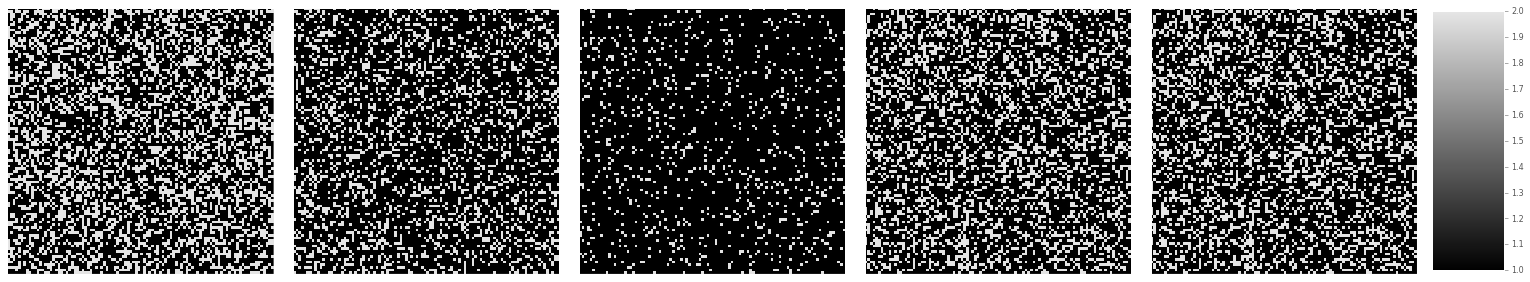

In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pylab as plt
from pymks.tools import draw_microstructures

X_con = np.concatenate((X, Y, Z, R1, R2))
draw_microstructures((X_con[::201]))

And the corresponding final microstructures after simulation (200 Monte-Carlo steps) look like these:

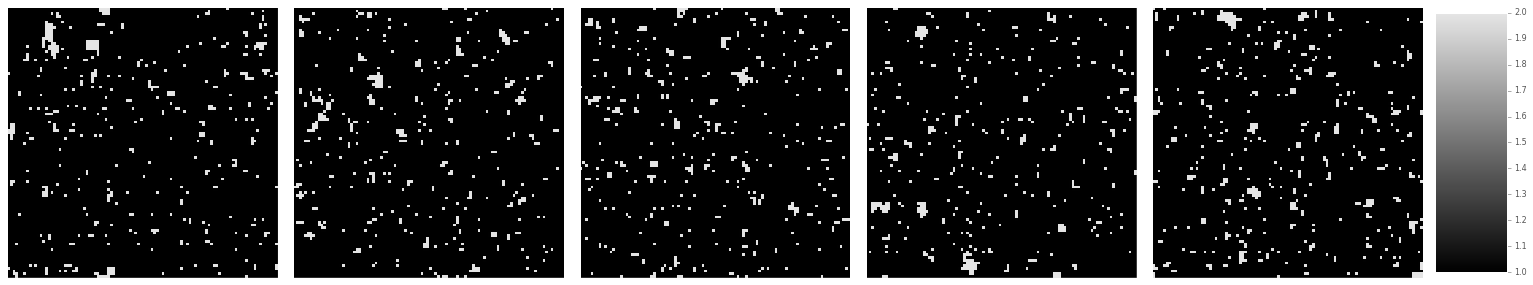

In [81]:
draw_microstructures((X_con[200::201]))

So, this is a microstructure evolution problem, and final microstructures look very similar to my eyes. Can we check it using PyMKS tools? We have 200 files for each simulation, so we can also take a look at path each simulation takes.


To get started, we are going to perform 2-point statistics first for couple of microstructures using autocorrelate from pymks.stats :

The correlations can be plotted using draw_autocorrelations from pymks.tools. Here 10th step is plotted since initial is completely random microstructure and its statistics does not look exciting. But you can change around that 10 and take al ook at different simulation steps.

In [56]:

from pymks.stats import autocorrelate
from pymks.stats import crosscorrelate
from pymks.tools import draw_autocorrelations

prim_basis = PrimitiveBasis(n_states=2,domain=[1, 2])
X_ = prim_basis.discretize(X)
X_auto = correlate(X_, periodic_axes=(0, 1), correlations=[(0, 0),(1, 1)])

X_auto.shape

(201, 100, 100, 2)

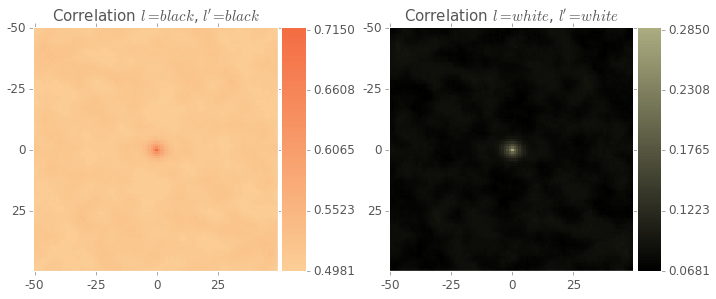

Volume fraction of black phase 0.6099
Volume fraction of white phase 0.3901


In [57]:
correlations = [('black', 'black'), ('white', 'white')]
draw_autocorrelations(X_auto[10], autocorrelations=correlations)

center = (X_auto.shape[2]) / 2
print 'Volume fraction of black phase', X_auto[0, center, center, 0]
print 'Volume fraction of white phase', X_auto[0, center, center, 1]

And the final microstructures do not look much interesting since it's mostly has black state:

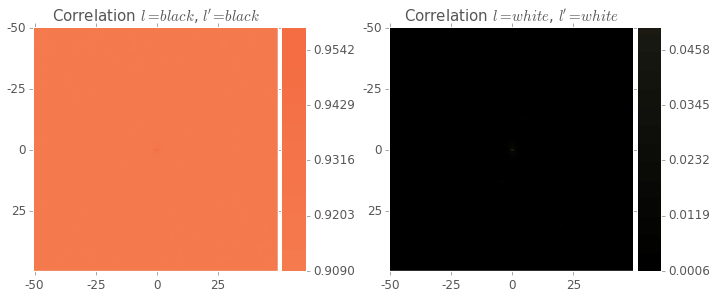

Volume fraction of black phase 0.9542
Volume fraction of white phase 0.0458


In [58]:
draw_autocorrelations(X_auto[200], autocorrelations=correlations)
print 'Volume fraction of black phase', X_auto[200, center, center, 0]
print 'Volume fraction of white phase', X_auto[200, center, center, 1]

Using MKSStructureAnalysis we can perform 2-points statistics and dimentionality reduction (PCA) right after. So we are not going to use whatever we have done in the previous section, it was just to show how 2-point statistics look like for our data.
We have to concatenate 3 sets of data and perform everything together.

In [64]:
from pymks import MKSStructureAnalysis
from pymks.bases import PrimitiveBasis

leg_basis = PrimitiveBasis(n_states=2, domain=[1, 2])
analyzer = MKSStructureAnalysis(basis=leg_basis, mean_center=False)

XY_PCA=analyzer.fit_transform(X_con,periodic_axes=[0,1])
XY_PCA.shape

(1005, 5)

R1 and R2 are two different simulation results with the same initial microstructure, but different seeds for random number generation for Monte-Carlo simulations. The hope is to see that the same initial microstructure will take two different paths and will end up in quite the same spot. Let's check it!

So let's take a look at PCA plot:

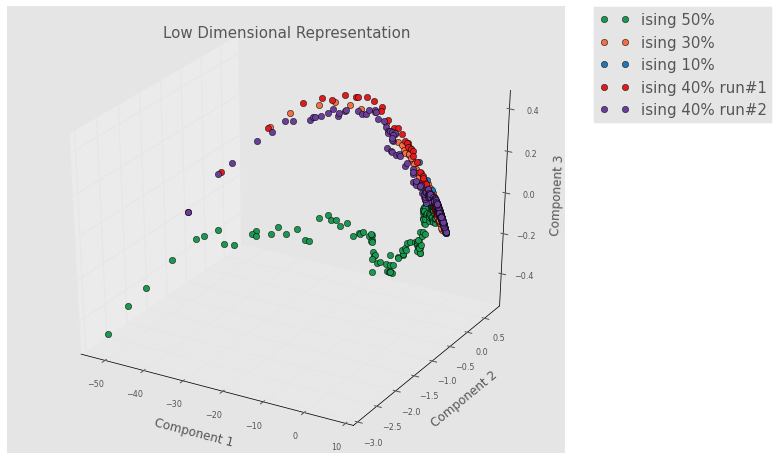

In [66]:
from pymks.tools import draw_components

draw_components([XY_PCA[0:201, :3],XY_PCA[201:402, :3],XY_PCA[402:603, :3],XY_PCA[603:804, :3],XY_PCA[804:1005, :3]],
                ['ising 50%','ising 30%','ising 10%','ising 40% run#1','ising 40% run#2'], 
                view_angles=(30,-60), legend_outside=True, figsize=(10,8))

Looks cool but not clear! Now, let's see how final structures are close to each other, so we are plotting only final five points:

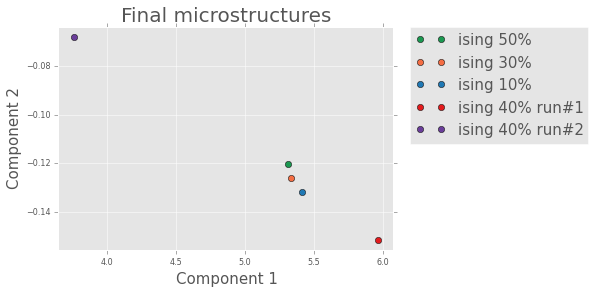

In [94]:
draw_components([XY_PCA[200:201, :2],XY_PCA[401:402, :2],XY_PCA[602:603, :2],XY_PCA[803:804, :2],XY_PCA[1004:1005, :2]],
                ['ising 50%','ising 30%','ising 10%','ising 40% run#1','ising 40% run#2'],
               legend_outside=True, title='Final microstructures')

I think they are close enough, or maybe not...


Similarly, we can plot initial points. Red point is not visible, because it's exact the same as purple one.

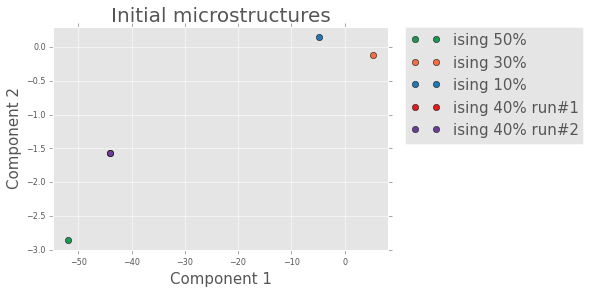

In [93]:
draw_components([XY_PCA[0:1, :2],XY_PCA[200:201, :2],XY_PCA[402:403, :2],XY_PCA[603:604, :2],XY_PCA[804:805, :2]],
                ['ising 50%','ising 30%','ising 10%','ising 40% run#1','ising 40% run#2'],
                legend_outside=True, title='Initial microstructures')

Now, we can use different kernel for dimensionality reduction within scikit-learn package:


In [95]:

from pymks.stats import autocorrelate
from pymks.stats import crosscorrelate
from pymks.stats import correlate
from pymks import PrimitiveBasis

X_ = prim_basis.discretize(X_con)
X_corr = correlate(X_, periodic_axes=(0, 1), correlations=[(0, 0), (0, 1)])
X_corr.shape    

(1005, 100, 100, 2)

In [96]:
Xcorr_reshape= X_corr.reshape((1005, -1))
Xcorr_reshape.shape

(1005, 20000)

In [97]:
from sklearn.decomposition import PCA, KernelPCA


kpca = KernelPCA(n_components=3,kernel='rbf')#, gamma=None, degree=3, coef0=1, kernel_params=None, alpha=1.0, 
           #      fit_inverse_transform=False, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False)
X_kpca = kpca.fit_transform(Xcorr_reshape)
X_kpca.shape

(1005, 3)

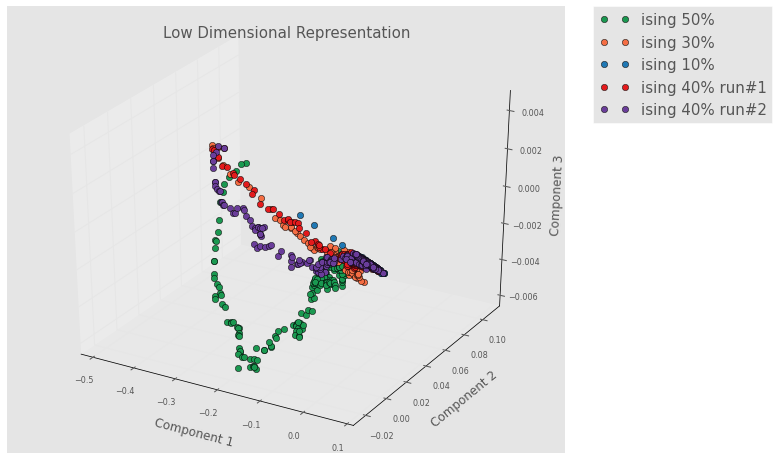

In [98]:
draw_components([X_kpca[0:201, :3],X_kpca[201:402, :3],X_kpca[402:603, :3],X_kpca[603:804, :3],X_kpca[804:1005, :3]],
                ['ising 50%','ising 30%','ising 10%', 'ising 40% run#1','ising 40% run#2'],
                legend_outside=True,figsize=(10,8),view_angles=(30,-60))

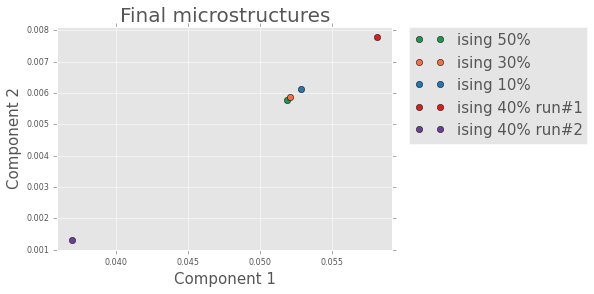

In [101]:
draw_components([X_kpca[200:201, :2],X_kpca[401:402, :2],X_kpca[602:603, :2],X_kpca[803:804, :2],X_kpca[1004:1005, :2]],
                ['ising 50%','ising 30%','ising 10%','ising 40% run#1','ising 40% run#2'],
               legend_outside=True, title='Final microstructures')

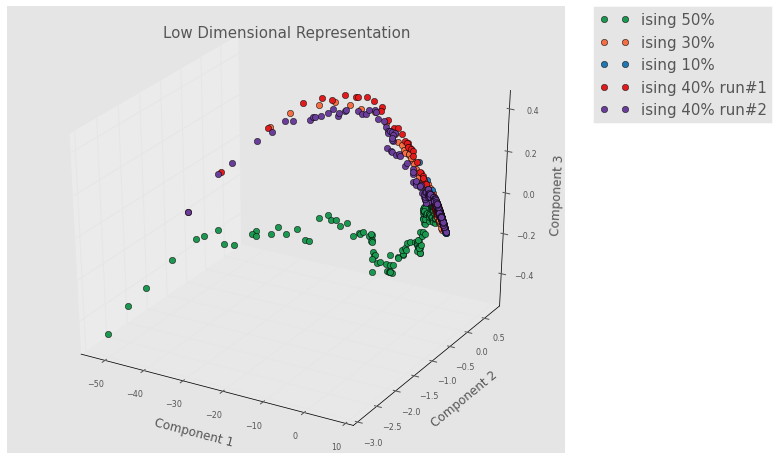

In [99]:
draw_components([XY_PCA[0:201, :3],XY_PCA[201:402, :3],XY_PCA[402:603, :3],XY_PCA[603:804, :3],XY_PCA[804:1005, :3]],
                ['ising 50%','ising 30%','ising 10%','ising 40% run#1','ising 40% run#2'], 
                view_angles=(30,-60), legend_outside=True, figsize=(10,8))

In [100]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel

K = chi2_kernel(Xcorr_reshape, gamma=0.1)
K.shape


(1005, 1005)

In [84]:
KpcaChi = KernelPCA(n_components=3,kernel='precomputed')
X_chi = KpcaChi.fit_transform(K)
X_chi.shape

(1005, 3)

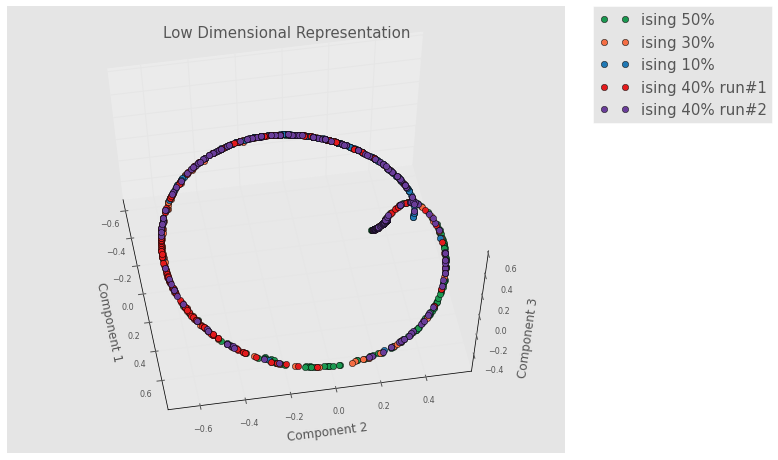

In [85]:
draw_components([X_chi[0:201, :3],X_chi[201:402, :3],X_chi[402:603, :3],X_chi[603:804, :3],X_chi[804:1005, :3]],
                ['ising 50%','ising 30%','ising 10%', 'ising 40% run#1','ising 40% run#2'],
    legend_outside=True, view_angles=(60,-10),figsize=(10,8))